In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from tensorflow.keras import Sequential
import numpy as np
from tensorflow.keras.layers import Dense, Input, MaxPooling2D, Dropout, Flatten
from tensorflow.keras import metrics
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
img_height = 400
img_width = 400
batch_size = 32
epochs = 10

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_directory('data/train',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')

valid_generator = datagen.flow_from_directory('data/test',
                                                    target_size=(img_height, img_width),
                                                    batch_size=batch_size,
                                                    class_mode='categorical')


Found 7630 images belonging to 2 classes.
Found 1907 images belonging to 2 classes.


In [4]:
# pretrained된 VGG16모델을 가져온다.
# https://keras.io/api/applications/vgg/#vgg16-function
pretrained_model = tf.keras.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(img_height, img_width, 3),
    pooling=None
)

In [5]:
pretrained_model.trainable = False    # VGG16의 가중치들은 학습이 이루어지지 않도록 한다

model = Sequential()

# CAM을 위해 하단에 다른 레이어를 추가해야하기 때문에 VGG16의 맨 마지막 레이어(pooling layer)를 제외하고 나머지 레이어를 model에 추가해준다
for layer in pretrained_model.layers[:-1]:
    model.add(layer)

# CAM을 구현하기 위해 Conv2D, GlobalAveragePolling2D, Dense 레이어를 추가해준다
model.add(tf.keras.layers.Conv2D(filters=1024, kernel_size=(3, 3), padding='same', activation='relu'))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(2, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=[metrics.AUC(), 'accuracy'])


In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 400, 400, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 400, 400, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 200, 200, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 200, 200, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 200, 200, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 100, 100, 128)     0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 100, 100, 256)     2

In [7]:
history = model.fit(
  train_generator,
  steps_per_epoch=train_generator.samples//batch_size,
  validation_data=valid_generator,
  validation_steps=valid_generator.samples//batch_size,
  epochs=epochs
)

Epoch 1/10
238/238 [==============================] - 197s 826ms/step - loss: 0.4675 - auc: 0.8652 - accuracy: 0.7819 - val_loss: 0.3943 - val_auc: 0.9058 - val_accuracy: 0.8374
Epoch 2/10
238/238 [==============================] - 196s 823ms/step - loss: 0.3069 - auc: 0.9433 - accuracy: 0.8705 - val_loss: 0.3136 - val_auc: 0.9406 - val_accuracy: 0.8644
Epoch 3/10
238/238 [==============================] - 196s 824ms/step - loss: 0.2697 - auc: 0.9561 - accuracy: 0.8927 - val_loss: 0.2425 - val_auc: 0.9661 - val_accuracy: 0.9052
Epoch 4/10
238/238 [==============================] - 196s 825ms/step - loss: 0.2462 - auc: 0.9635 - accuracy: 0.9044 - val_loss: 0.2490 - val_auc: 0.9625 - val_accuracy: 0.8988
Epoch 5/10
238/238 [==============================] - 196s 825ms/step - loss: 0.2213 - auc: 0.9701 - accuracy: 0.9197 - val_loss: 0.1862 - val_auc: 0.9783 - val_accuracy: 0.9396
Epoch 6/10
238/238 [==============================] - 197s 826ms/step - loss: 0.1937 - auc: 0.9766 - accuracy:

In [8]:
# 참고
# https://dryjelly.tistory.com/147
# https://github.com/jacobgil/keras-cam/blob/master/cam.py

import matplotlib.pyplot as plt
import numpy as np
import cv2
%matplotlib inline

get_output = tf.keras.backend.function([model.layers[0].input],
                                       [model.layers[-3].output, model.layers[-1].output])    # 이미지 입력을 받아 model의 마지막에 추가한 Conv2D와 Dense 레이어를 출력하는 모델
[conv_outputs, predictions] = get_output(np.array([valid_generator[0][0][0]]))                # 이미지 입력
conv_outputs = conv_outputs[0, :, :, :]

class_weights = model.layers[-1].get_weights()[0]    # model의 맨 마지막 레이어인 Dense 레이어의 weight를 가져온다

cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
for i, w in enumerate(class_weights[:, 1]):
        cam += w * conv_outputs[:, :, i]    # 마지막 레이어의 각 가중치와 Conv2D의 결과를 곱하여 누적하여 가산 -> CAM 구현

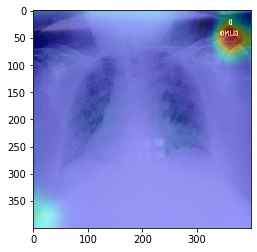

In [9]:
# 결과 이미지를 보기 좋게 가공

# CAM 이미지의 값 범위를 0 부터 255까지로 맞추고
# 이미지 크기를 원본 데이터와 일치하도록 resize한다
heatmap = cam
heatmap = heatmap / (np.max(heatmap) - np.min(heatmap)) * 255.9
heatmap = np.uint8(heatmap - np.min(heatmap))
heatmap = cv2.resize(heatmap, (img_height, img_width))
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 원본 이미지도 비슷하게 처리
origin_img = valid_generator[0][0][0]
origin_img = origin_img / (np.max(origin_img) - np.min(origin_img)) * 255.9
origin_img = np.uint8(origin_img - np.min(origin_img))

# 원본 이미지와 CAM 합성
a = 0.6
dst = cv2.addWeighted(origin_img, a, heatmap, 1 - a, 0)
plt.imshow(dst)

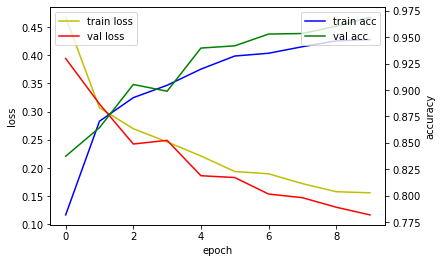

In [14]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper right')

plt.show()